In [ ]:
# First cell (new)
!pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
  Using cached https://download.pytorch.org/whl/filelock-3.19.1-py3-none-any.whl.metadata (2.1 kB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.15.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached https://download.pytorch.org/whl/networkx-3.5-py3-none-any.whl.metadata (6.3 kB)
  Using cached https://download.pytorch.org/whl/jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached https://download.pytorch.org/whl/fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import h5py # pour gérer les formats de données utilisés ici
from scipy.signal import welch
from sklearn.metrics import confusion_matrix




Mounted at /content/drive


In [3]:
for p in [
    "/content/drive/MyDrive/train.hdf5",
    "/content/drive/MyDrive/validation.hdf5",
    "/content/drive/MyDrive/test.hdf5"
]:
    print("\n>>> Checking", p)
    with h5py.File(p, "r") as f:
        print("signals:", f["signaux"].shape)
        print("labels :", f["labels"].shape)
        print("snr    :", f["snr"].shape)



>>> Checking /content/drive/MyDrive/train.hdf5
signals: (30000, 2048, 2)
labels : (30000,)
snr    : (30000,)

>>> Checking /content/drive/MyDrive/validation.hdf5
signals: (10000, 2048, 2)
labels : (10000,)
snr    : (10000,)

>>> Checking /content/drive/MyDrive/test.hdf5
signals: (10000, 2048, 2)
labels : (10000,)
snr    : (10000,)


### TP3: Reconnaissance de signaux de communication par apprentissage profond

<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb

2 séances de TP sur ce sujet : le 5 novembre (1h00), le 12 novembre (3h).
Le cours du 19 novembre sera partagé en 3 : cours sur la séparation de sources audio / présentation des mini projets et organisation des soutenances / fin de ce TP.<br>
Deadline pour le rendu du TP: 26 novembre 2025, 13h59, par mail à deepetsignal.mva@gmail.com <br>

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook.
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.

---

## Ruben, CARDOSO  | Shubha Sanket, SAMANTARAY

---



## Problématique

On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur
de 2048 échantillons IQ (In Phase / Quadrature) ie le signal prend des valeurs complexes. On représente la partie
réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié.

L'émetteur peut provenir de 6 catégories différentes.
Les paramètres différenciant les différentes catégories sont
- le type de modulation
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données
- le débit de la transmission

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0.


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation
électromagnétique comme :
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. Lors de ce TP nous rencontrerons 4 niveaux de SNR: 30 dB (facile), 20 dB, 10 dB et 0 dB (en espérant qu'on puisse faire quelque chose de ces données).
Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

Les objectifs de ce TP sont:

1. Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch
2. Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html.
3. Qualifier les performances de votre réseau de neurones sur l'ensemble de test via:
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation d'un graphique accuracy vs SNR
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
4. Rapporter les performances de vos architectures à leur complexité, la complexité d'un réseau de neurones étant ici résumé au nombre de paramètres libres qu'il fait intervenir

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation.


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet.
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones".

Surtout privilégiez dans un premier temps la simplicité quitte à complexifier votre approche ensuite pour doper ses performances. Ne restez pas bloqué sur des réseaux qui "mettent trop de temps à apprendre"

# I/  Chargement des données en numpy

Le TP est composé de trois jeux de données :
- train.hdf5 destiné à nourrir l'entrainement de réseaux de neurones
- test.hdf5 destiné à évaluer les algorithmes après entrainement
- samples.hdf5 qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [4]:
data_path = '/content/drive/MyDrive/samples.hdf5'

data_sample = h5py.File(data_path , 'r')

signals = np.array(data_sample['signaux'])
snr =  np.array(data_sample['snr'])
labels_id = np.array(data_sample['labels'])

data_sample.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [5]:
def get_labels(open_h5_file):
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

### Visualisation des données

Commencez par étudier les données:

    - observez leur taille
    - la distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
    - visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez

Remarque : dans ce TP il n'y a pas beaucoup à gagner à faire du feature engineering

In [6]:
#Importation du Training set File :

data_train=h5py.File('/content/drive/MyDrive/train.hdf5','r')

signals_train= np.array(data_train['signaux'])
snr_train=  np.array(data_train['snr'])
labels_train = np.array(data_train['labels'])


get_labels(data_train)


{np.int64(1): 'N-PSK8',
 np.int64(0): 'N-QAM16',
 np.int64(2): 'N-QPSK',
 np.int64(4): 'W-PSK8-V1',
 np.int64(5): 'W-PSK8-V2',
 np.int64(3): 'W-QAM16'}

In [7]:
# Taille des jeux de données contenus dans le fichier

# Format initial du tenseur : (Batch, Time, Channel)
print(f"Shape original de signals_train : {signals_train.shape}  : format [B, T, C].")
print("Cela correspond à 30 000 signaux, chacun composé de 2048 échantillons temporels "
      "et de 2 canaux (I et Q).\n")

# Conversion vers le format attendu par PyTorch : [B, C, T]
signals_train = np.transpose(signals_train, (0, 2, 1))

# Nouveau format du tenseur après transposition
print(f"Shape transposé de signals_train : {signals_train.shape}  : format [B=30000, C=2, T=2048].")
print("Désormais, tous les modèles recevront des tenseurs au format [Batch, Channel, Time], "
      "conformément aux notes de cours.\n")

# Shapes du SNR et des labels
print(f"Shape du SNR    : {snr_train.shape}.")
print("Chaque signal est associé à une valeur de SNR (en dB), décrivant le niveau de bruit "
      "lors de l’acquisition.\n")

print(f"Shape des labels : {labels_train.shape}.")
print("Chaque label correspond à l’une des six catégories d’émetteurs que notre réseau "
      "de neurones doit prédire.\n")


Shape original de signals_train : (30000, 2048, 2)  : format [B, T, C].
Cela correspond à 30 000 signaux, chacun composé de 2048 échantillons temporels et de 2 canaux (I et Q).

Shape transposé de signals_train : (30000, 2, 2048)  : format [B=30000, C=2, T=2048].
Désormais, tous les modèles recevront des tenseurs au format [Batch, Channel, Time], conformément aux notes de cours.

Shape du SNR    : (30000,).
Chaque signal est associé à une valeur de SNR (en dB), décrivant le niveau de bruit lors de l’acquisition.

Shape des labels : (30000,).
Chaque label correspond à l’une des six catégories d’émetteurs que notre réseau de neurones doit prédire.



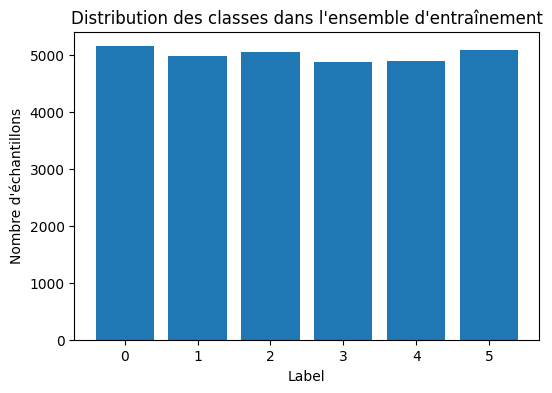

In [8]:
# Distribution des classes
unique_labels, counts_labels = np.unique(labels_train, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique_labels, counts_labels)
plt.xlabel("Label")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des classes dans l'ensemble d'entraînement")
plt.show()


On observe que les six classes sont approximativement équidistribuées. Cela s'apparente donc à une distribution uniforme.
---

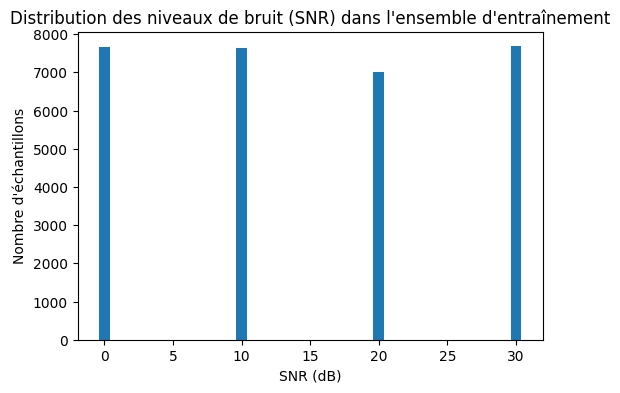

In [9]:
# Distribution des SNR
unique_snr, counts_snr = np.unique(snr_train, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique_snr, counts_snr)
plt.xlabel("SNR (dB)")
plt.ylabel("Nombre d'échantillons")
plt.title("Distribution des niveaux de bruit (SNR) dans l'ensemble d'entraînement")
plt.show()


Les quatre niveaux de SNR (0, 10, 20, 30 dB) sont représentés de manière relativement uniforme.
---

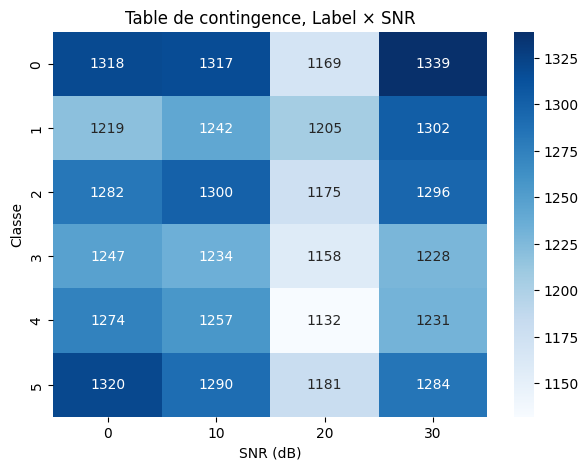

In [10]:
df = pd.DataFrame({
    'classe': labels_train,
    'snr': snr_train
})

pivot = pd.crosstab(df['classe'], df['snr'])

plt.figure(figsize=(7,5))
sns.heatmap(pivot, annot=True, fmt="d", cmap="Blues")
plt.title("Table de contingence, Label × SNR")
plt.ylabel("Classe")
plt.xlabel("SNR (dB)")
plt.show()


La matrice de contingence montre que chaque classe apparaît de manière homogène pour chaque niveau de SNR. Il n’existe pas de combinaison classe–SNR sur- ou sous-représentée.
---

signals_train shape : (30000, 2, 2048)
Example index : 0, class = 4, SNR = 0 dB


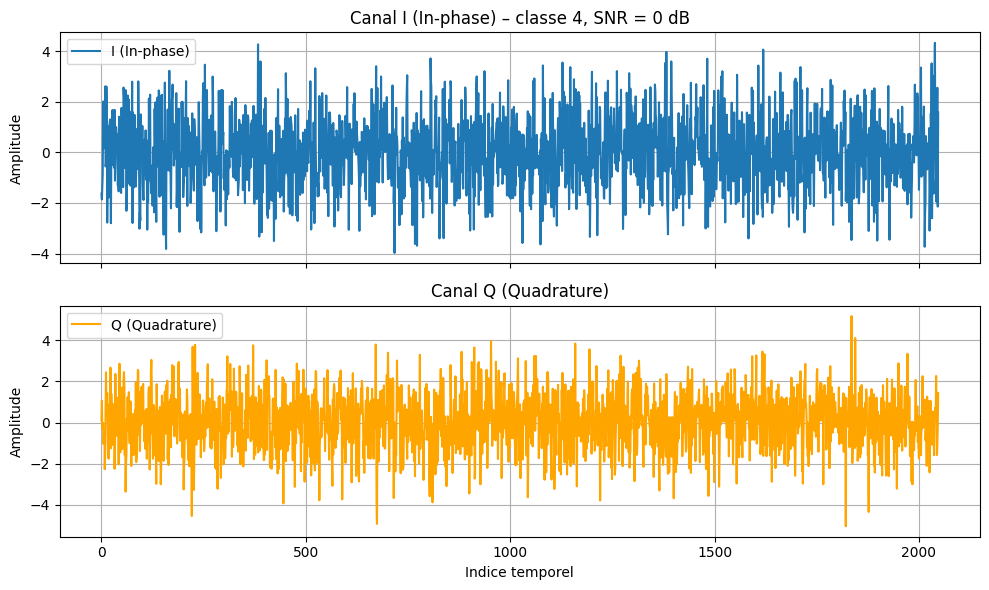

In [11]:
# Visualisation séparée des canaux I et Q pour un exemple de signal

idx = 0  # vous pouvez changer cet indice pour visualiser d'autres signaux

I = signals_train[idx, 0, :]  # canal In-phase
Q = signals_train[idx, 1, :]  # canal Quadrature

print(f"signals_train shape : {signals_train.shape}")
print(f"Example index : {idx}, class = {labels_train[idx]}, SNR = {snr_train[idx]} dB")

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Canal I
axes[0].plot(I, label="I (In-phase)")
axes[0].set_title(f"Canal I (In-phase) – classe {labels_train[idx]}, SNR = {snr_train[idx]} dB")
axes[0].set_ylabel("Amplitude")
axes[0].grid(True)
axes[0].legend()

# Canal Q
axes[1].plot(Q, color="orange",label="Q (Quadrature)")
axes[1].set_title("Canal Q (Quadrature)")
axes[1].set_xlabel("Indice temporel")
axes[1].set_ylabel("Amplitude")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


## Visualisation d’un signal IQ

Chaque signal est décrit par deux composantes réelles : la composante $I$ (*In-phase*) et la composante $Q$ (*Quadrature*).  
Elles forment ensemble un signal complexe :

$$
s(t) = I(t) + i\,Q(t)
$$

(où $i^2=-1$.)

### Diagrammes de constellation : comparaison entre SNR faibles et élevés

La représentation du signal dans le plan $(I; Q) = (\mathbb{R}; i\mathbb{R})$ est appelée *diagramme de constellation*.  
Chaque point correspond à un échantillon du signal.

- Lorsque le SNR est **élevé** (ex : 30 dB), les points se regroupent autour des positions idéales de la modulation.
- Lorsque le SNR est **faible** (ex : 0 dB), le bruit domine et la constellation devient très dispersée.

Les figures ci-dessous illustrent clairement cette différence.


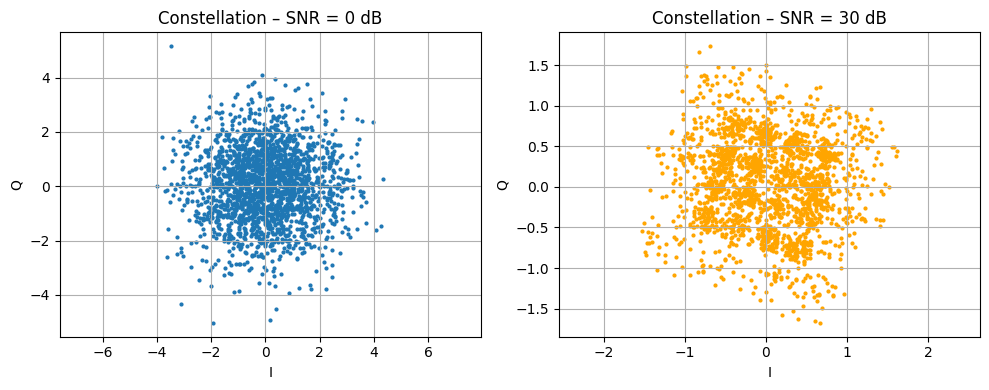

In [12]:
# Comparaison des constellations SNR = 0 dB vs SNR = 30 dB

# Trouver un exemple à 0 dB et un exemple à 30 dB
idx_0db = np.where(snr_train == 0)[0][0]
idx_30db = np.where(snr_train == 30)[0][0]

I_0,  Q_0  = signals_train[idx_0db,  0, :], signals_train[idx_0db,  1, :]
I_30, Q_30 = signals_train[idx_30db, 0, :], signals_train[idx_30db, 1, :]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# SNR = 0 dB
axes[0].scatter(I_0, Q_0, s=4)
axes[0].set_title("Constellation – SNR = 0 dB")
axes[0].set_xlabel("I")
axes[0].set_ylabel("Q")
axes[0].grid(True)
axes[0].axis("equal")

# SNR = 30 dB
axes[1].scatter(I_30, Q_30, s=4, color="orange")
axes[1].set_title("Constellation – SNR = 30 dB")
axes[1].set_xlabel("I")
axes[1].set_ylabel("Q")
axes[1].grid(True)
axes[1].axis("equal")

plt.tight_layout()
plt.show()


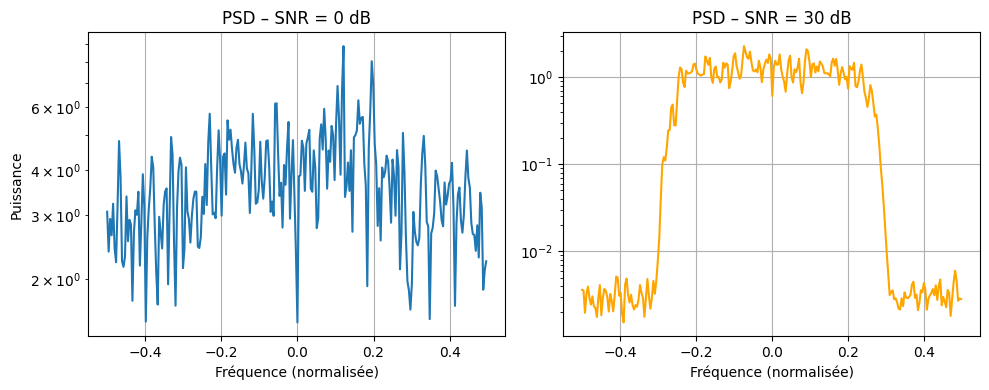

In [13]:
from scipy.signal import welch

def compute_psd_from_iq_sorted(idx, nperseg=256):
    """
    Calcule la PSD d'un signal IQ.
    """
    I = signals_train[idx, 0, :]
    Q = signals_train[idx, 1, :]
    s_complex = I + 1j * Q

    f, Pxx = welch(
        s_complex,
        nperseg=nperseg,
        return_onesided=False,
        scaling="density"
    )
    order = np.argsort(f)
    return f[order], Pxx[order]


# Un exemple à 0 dB et un exemple à 30 dB
idx_0db  = np.where(snr_train == 0)[0][0]
idx_30db = np.where(snr_train == 30)[0][0]

f0,  Pxx0  = compute_psd_from_iq_sorted(idx_0db)
f30, Pxx30 = compute_psd_from_iq_sorted(idx_30db)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

# PSD à 0 dB
axes[0].semilogy(f0, np.abs(Pxx0))
axes[0].set_title("PSD – SNR = 0 dB")
axes[0].set_xlabel("Fréquence (normalisée)")
axes[0].set_ylabel("Puissance")
axes[0].grid(True)

# PSD à 30 dB
axes[1].semilogy(f30, np.abs(Pxx30), color="orange")
axes[1].set_title("PSD – SNR = 30 dB")
axes[1].set_xlabel("Fréquence (normalisée)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


La PSD montre la répartition de la puissance du signal en fonction de la fréquence, ce qui permet d’observer la bande passante et d’éventuels décalages fréquentiels.  
Ces deux graphes comparent les spectres de puissance pour des SNR de 0 dB et 30 dB.
---

# II/ Chargement des données en Pytorch

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch.
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets :
    - un Dataset qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
    - un Dataloader qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones
    
Un dataset prend la forme
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, lablel_i), data_i étant un signal et label_i le label associé au signal
        ...
```

Implémentez une classe Dataset pour le dataset considéré ici

In [7]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_data):
        self.data = h5py.File(path_to_data, 'r')
        self.signals = np.array(self.data['signaux'])
        self.snr = np.array(self.data['snr'])
        self.labels = np.array(self.data['labels'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
      x = torch.tensor(self.signals[i], dtype=torch.float32)
      y = torch.tensor(self.labels[i], dtype=torch.long)
      return x, y



Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [8]:
dataset=MyDataset('/content/drive/MyDrive/samples.hdf5')

In [9]:
print("---Test du DataLoader:---\n")

x, y = dataset[0]

print("Shape du signal x :", x.shape)
print("Label associé y   :", y)
print(" - 2048 = longueur temporelle du signal")
print(" - 2    = canaux I/Q (In-phase / Quadrature)")


---Test du DataLoader:---

Shape du signal x : torch.Size([2048, 2])
Label associé y   : tensor(2)
 - 2048 = longueur temporelle du signal
 - 2    = canaux I/Q (In-phase / Quadrature)


Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset.
La cellule suivante donne un exemple d'utilisation

In [10]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset,
                        batch_size=10,
                        shuffle=True
                       )

Testez le dataloader pour différentes valeurs de batch_size

In [11]:
batchsize=[10,32,64,100]

for bs in batchsize:
    print(f"\nBatch size = {bs}")
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=True)

    x, label = next(iter(dataloader))
    print("x shape:", x.shape)
    print("label shape:", label.shape)



Batch size = 10
x shape: torch.Size([10, 2048, 2])
label shape: torch.Size([10])

Batch size = 32
x shape: torch.Size([32, 2048, 2])
label shape: torch.Size([32])

Batch size = 64
x shape: torch.Size([64, 2048, 2])
label shape: torch.Size([64])

Batch size = 100
x shape: torch.Size([100, 2048, 2])
label shape: torch.Size([100])


---
*Le fichier samples.hdf5 ne contient que 200 échantillons. Avec un dataset aussi réduit, des batch_size trop grands seraient inutiles ou empêcheraient l’itération correcte sur les données. J'ai donc choisi des batch allant jusqu'à la moitié de la taille totale du fichier en question.*


---
## Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement

Définissez un premier modèle Pytorch qui prend en entrée un batch de données (tenseur de dimensions [B , C, T] avec B la taille du batch, C le nombre de canaux des signaux et T le nombre d'échantillons dans les signaux) et renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez) (tenseur de dimensions [B,N] où N est le nombre de classe à identifier).

Ce modèle doit comporter moins de 10000 paramètres libres.

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [14]:
class DUMBNeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # modèle dump : trivial, le prédicteur n'est qu'une combinaison linéaire de notre input. (underfitting très probable).
        self.linear = nn.Linear(2, 6)

    def forward(self, x):
        # x vient du DataLoader : [B, 2048, 2] = [B, T, C]
        # on remet au format [B, C, T]
        x = x.permute(0, 2, 1)      # -> [B, C, T] = [B,2,2048]
        # on moyenne sur le temps T
        x = x.mean(dim=-1)          # -> [B, C]
        logits = self.linear(x)     # -> [B, n_classes=6] (n_classes= nombre de labels)
        return logits

Instanciez votre modèle et testez la consistence des dimensions de ses entrées et de ses sorties vis à vis des données étudiées. Il s'agit d'un test purement fonctionnel, pas besoin de chercher à réaliser un entraînement à ce point.

In [15]:
dumb=DUMBNeuralNetwork()

In [16]:
logits=dumb(x)
logits.shape #the shape is indeed in correct form : [B,N], N=n_classes

torch.Size([100, 6])

Estimez par un calcul "théorique" le nombre de paramètres du modèle que vous avez défini et vérifié que le modèle a bien ce nombre de paramètres en pratique par exemple en utilisant la fonction suivante :

In [17]:
def count_n_param(model):
    return sum([p.numel() for p in model.parameters()])

count_n_param(dumb)

18

Le modèle *dumb* contient une unique couche linéaire :  
$ \text{Linear}(2, 6) $

Cette couche comporte :  
- une matrice de poids de taille $6 \times 2$, soit $6 \times 2 = 12$ paramètres ;  
- un vecteur de biais de taille $6$.

Le nombre total de paramètres est donc :  
$ 12 + 6 = 18 $.

Ce résultat correspond exactement à la valeur retournée par `count_n_param(dumb)`.


## Mise en place de la pipeline d'entraînement

La pipeline d'entrainement consiste à
- charger les données
- les batcher
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires

Un cavnevas d'implémentation pourrait être:

```python
device = 'cpu' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU

model = ...  # vous instanciez ici votre modèle

loss = .... # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = ... # le nombre d'itérations dans l'entrainement

chemin_vers_sauvegarde_model = # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard.

model.to(device) # on place le modèle dans le GPU si nécessaire

for epoch in range(n_epochs):
    
    for batch_x,batch_y in dataloader_train:
        
        batch_x.to(device)
        batch_y.to(device)
        
        optimizer.zero_grad()
        
        batch_y_predicted = model(batch_x)
        
        l = loss(batch_y_predicted, batch_y)
        # loggez la loss sur le batch d'entraînement
        
        l.backward()
        
        optimizer.step()
        
    for batch_x,batch_y in dataloader_valid:
        
        batch_x.to(device)
        batch_y.to(device)
        
        with torch.no_grad():
            batch_y_predicted = model(batch_x)  
            
        # loggez la loss et les métriques sur le batch de validation

torch.save(model, chemin_vers_sauvegarde_model)

```

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs.

In [18]:
n = len(dataset)
n_train = int(0.8 * n)
n_valid = n - n_train

train_ds, valid_ds = random_split(dataset, [n_train, n_valid])

dataloader_train = DataLoader(train_ds, batch_size=64, shuffle=True)
dataloader_valid = DataLoader(valid_ds, batch_size=64, shuffle=False)

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DUMBNeuralNetwork().to(device)

criterion = nn.CrossEntropyLoss()     #notre fonction renvoie des réels donc il faut appliquer cette fonction qui fait log-softmax puis NLLL.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #learning rate = 0.001

n_epochs = 20 #arbitraire, à faire varier pour optimiser l'accuracy.
ACC=np.array([])

for epoch in range(n_epochs):

    # ----- TRAIN -----
    model.train()
    for batch_X, batch_y in dataloader_train:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()              # on remet les gradients à zéro à chaque itération.

        batch_y_pred = model(batch_X)      # logits de taille [B, 6]
        loss = criterion(batch_y_pred, batch_y)

        loss.backward()                    # backpropagation pour le calcul des gradients de la loss.
        optimizer.step()

    # ----- VALID -----
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for batch_X, batch_y in dataloader_valid:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            batch_y_pred = model(batch_X)
            loss = criterion(batch_y_pred, batch_y)

            test_loss += loss.item() * batch_X.size(0)
            correct += (batch_y_pred.argmax(1) == batch_y).sum().item()

    test_loss /= len(dataloader_valid.dataset)
    accuracy = correct / len(dataloader_valid.dataset)
    ACC = np.append(ACC, accuracy)

    if epoch+1==20:
      print(f"Epoch finale: loss moyenne = {test_loss:.4f}, accuracy moyenne = {accuracy:.8f}")


print(f"Meilleure accuracy : {ACC[np.argmax(ACC)]} obtenue à l'epoch {np.argmax(ACC)+1}".)


Epoch finale: loss moyenne = 1.9551, accuracy moyenne = 0.12500000
Meilleure accuracy : 0.125 obtenue à l'epoch 1


In [32]:
# --- SAUVEGARDE DU MODELE ---
save_path = "/content/drive/MyDrive/dumb_model.pth"
torch.save(model.state_dict(), save_path)
print("Modèle sauvegardé dans :", save_path)


Modèle sauvegardé dans : /content/drive/MyDrive/dumb_model.pth


Vérifiez que vous avez bien enregistré votre modèle en fin d'entrainement. Chargez le avec la fonction
```python
modele = torch.load(...)
```
et vérifiez que vous pouvez l'utiliser sur des données du problème.

In [33]:
# --- CHARGEMENT DU MODELE SAUVEGARDE ---
loaded_model = DUMBNeuralNetwork().to(device)
loaded_model.load_state_dict(torch.load("/content/drive/MyDrive/dumb_model.pth"))
loaded_model.eval()

print("Modèle rechargé avec succès !")


Modèle rechargé avec succès !


In [34]:
with torch.no_grad():
    batch_X, batch_y = next(iter(dataloader_valid))       # un batch de validation
    batch_X = batch_X.to(device)

    logits = loaded_model(batch_X)                        # prédictions du modèle
    predicted_labels = logits.argmax(dim=1)               # classe prédite

print("Labels prédits :", predicted_labels[:10].cpu().numpy())
print("Labels réels :", batch_y[:10].cpu().numpy())


Labels prédits : [5 5 5 5 5 5 5 5 5 5]
Labels réels : [3 1 4 0 5 1 4 0 1 0]


*Comme attendu pour un modèle “dumb”, les prédictions sont quasiment constantes et ne correspondent pas aux vraies classes : ce comportement confirme que le chargement du modèle fonctionne correctement, mais qu’un modèle plus sophistiqué sera nécessaire pour obtenir de bonnes performances.*
___


# Entraînement de réseaux de neurones

Dans cette partie vous définissez une ou si vous avancez suffisamment vite plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement.
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Dans un deuxième temps, si vous le souhaitez vous pouvez tenter de mettre en place des stratégies autour de l'utilisation des données d'entraînement pour améliorer vos résultats. Si vous cherchez à mettre en place de l'augmentation de données vous pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch.

In [35]:
train_dataset = MyDataset('/content/drive/MyDrive/train.hdf5')
valid_dataset = MyDataset('/content/drive/MyDrive/validation.hdf5')
test_dataset  = MyDataset('/content/drive/MyDrive/test.hdf5')

# Dataloaders
dataloader_train = DataLoader(train_dataset, batch_size=64, shuffle=True)
dataloader_valid = DataLoader(valid_dataset, batch_size=64, shuffle=False)
dataloader_test  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print("Datasets loaded:")
print("  Training samples   =", len(train_dataset))
print("  Validation samples =", len(valid_dataset))
print("  Test samples       =", len(test_dataset))

Datasets loaded:
  Training samples   = 30000
  Validation samples = 10000
  Test samples       = 10000


In [36]:
# Listes globales pour faire le résumé final de tous les modèles
if 'summary_model_names' not in globals():
    summary_model_names = []
    summary_best_val_accs = []
    summary_best_model_paths = []

### Model M1 — Fully Connected Network (MLP)

Ce modèle de base traite le signal IQ comme un long vecteur et n’applique que des couches entièrement connectées (denses).
Il n’exploite ni la structure temporelle, ni la localité convolutionnelle, ni la mémoire récurrente. Son objectif n’est pas d’obtenir une haute précision, mais de fournir un niveau de performance de référence auquel des architectures plus sophistiquées pourront être comparées.
Un écart de performance important entre ce MLP et les modèles ultérieurs montrera l’importance d’exploiter la structure temporelle de l’entrée.


In [37]:
class MLP_FC(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),                        # [B, 2048*2]
            nn.Linear(2048*2, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        return self.net(x)


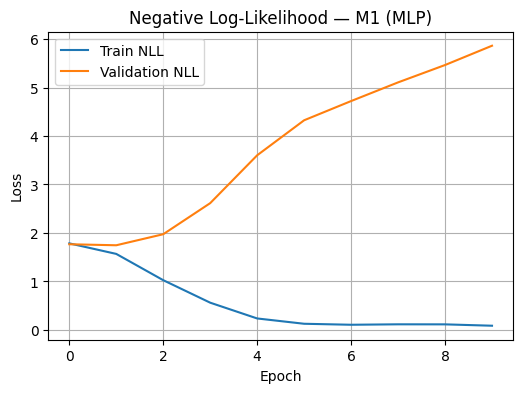

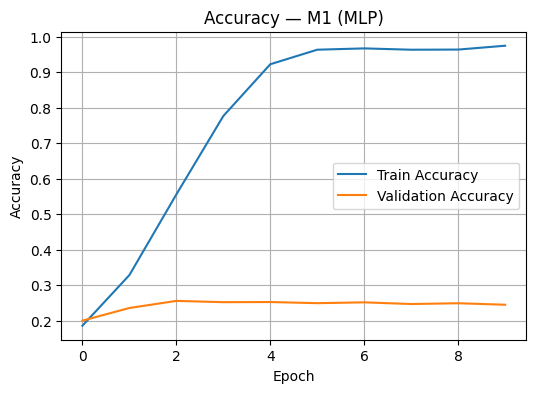

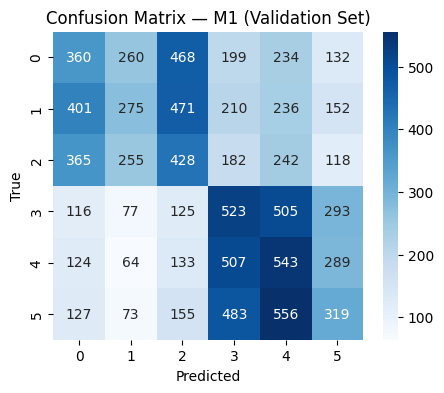


SUMMARY — M1
Best validation accuracy: 0.2556 at epoch 3
Best model stored at: /content/drive/MyDrive/M1_best.pth
Last model stored at:  /content/drive/MyDrive/M1_last.pth


In [40]:
# ===================== MODEL + OPTIMIZER =====================

model = MLP_FC().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
n_epochs = 10

best_val_acc = 0.0
best_model_path = "/content/drive/MyDrive/M1_best.pth"
last_model_path = "/content/drive/MyDrive/M1_last.pth"


# ===================== TRAINING LOOP =====================

for epoch in range(1, n_epochs+1):

    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in dataloader_train:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total   += X.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # ---- VALIDATION ----
    model.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += X.size(0)

    val_losses.append(val_loss_sum / total)
    val_accs.append(correct / total)

    # ---- SAVE BEST MODEL (SANS PRINT) ----
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        torch.save(model.state_dict(), best_model_path)

# ---- SAVE LAST MODEL ALWAYS ----
torch.save(model.state_dict(), last_model_path)


# ===================== CONFUSION MATRIX ON VALIDATION =====================

y_true = []
y_pred = []
model.eval()

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        logits = model(X)
        preds = logits.argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


# ===================== PLOTS =====================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — M1 (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — M1 (MLP)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — M1 (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

best_epoch = int(np.argmax(val_accs)) + 1
print("\nSUMMARY — M1")
print(f"Best validation accuracy: {max(val_accs):.4f} at epoch {best_epoch}")
print(f"Best model stored at: {best_model_path}")
print(f"Last model stored at:  {last_model_path}")
# ====== Stockage global pour le résumé final ======
summary_model_names.append("M1_MLP")
summary_best_val_accs.append(best_val_acc)
summary_best_model_paths.append(best_model_path)



### Summary — Model M1 (Fully Connected Network)

Le modèle de base M1 traite le signal IQ comme un simple vecteur aplati et n’exploite pas sa structure temporelle.
Les résultats d’entraînement montrent une forte baisse de la loss d’entraînement et une hausse rapide de l’accuracy d’entraînement, tandis que l’accuracy de validation reste faible et que la loss de validation augmente après quelques epochs.
Cela indique un overfitting manifeste : le modèle mémorise le jeu d’entraînement mais ne parvient pas à généraliser aux données non vues.

Ces résultats sont attendus pour un MLP appliqué à des données de modulation, puisque cette architecture ignore les motifs temporels à court terme ainsi que l’évolution de l’amplitude et de la phase au cours du temps.
M1 sert donc de référence de base, en plus du Dumb model, dont le rôle est de mettre en évidence l’écart de performance attendu lorsqu’on passe à des architectures plus adaptées, telles que les CNN, RNN ou modèles hybrides.

### Model M2 — Convolutional Neural Network (1D-CNN)

Ce modèle interprète le signal IQ comme une séquence temporelle à 2 canaux et applique des convolutions 1D pour extraire des motifs locaux au fil du temps.
Contrairement à M1, il exploite explicitement la structure temporelle de l’onde, ce qui est essentiel dans les signaux de communication numérique où la forme des symboles, les structures pilotes et les schémas de modulation transportent des informations spécifiques à chaque classe.

Les couches de convolution et de max-pooling construisent progressivement des représentations de plus haut niveau, plus robustes aux désalignements temporels, aux rotations de phase et au bruit additif.
L’objectif de ce modèle est d’obtenir une amélioration significative par rapport au MLP de base en tirant parti de l’extraction de caractéristiques invariante par translation, plutôt qu’en traitant le signal comme un simple vecteur aplati.


In [42]:
class CNN_1D(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=5, padding=2),  # [B, 2, 2048] → [B, 32, 2048]
            nn.ReLU(),
            nn.MaxPool1d(2),                             # [B, 32, 1024]

            nn.Conv1d(32, 64, kernel_size=5, padding=2), # [B, 64, 1024]
            nn.ReLU(),
            nn.MaxPool1d(2),                             # [B, 64, 512]

            nn.Conv1d(64, 128, kernel_size=5, padding=2),# [B, 128, 512]
            nn.ReLU(),
            nn.MaxPool1d(2)                             # [B, 128, 256]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 256, 512),
            nn.ReLU(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)  # [B, 2048, 2] → [B, 2, 2048]
        x = self.cnn(x)
        return self.classifier(x)


In [43]:
# ====================== M2 — 1D CNN PIPELINE ======================

model = CNN_1D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
n_epochs = 25

best_val_acc    = 0.0
best_model_path = "/content/drive/MyDrive/M2_CNN_best.pth"
last_model_path = "/content/drive/MyDrive/M2_CNN_last.pth"

print("Training samples:", len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:", len(dataloader_test.dataset))

for epoch in range(1, n_epochs+1):

    # --------------------- TRAIN ---------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (X, y) in enumerate(dataloader_train):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # --------------------- VALID ---------------------
    model.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

    val_losses.append(val_loss_sum / total)
    val_accs.append(correct / total)

    # --------------------- SAVE BEST MODEL ---------------------
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ [M2] Best model updated — saved (Val Acc = {best_val_acc:.4f})")

# --------------------- SAVE FINAL MODEL ALWAYS ---------------------
torch.save(model.state_dict(), last_model_path)
print(f"\n[M2] Final model saved to {last_model_path}")

best_epoch = int(np.argmax(val_accs)) + 1
best_val = max(val_accs)

print("\n[M2] BEST VALIDATION ACCURACY:")
print(f"{best_val:.4f} at epoch {best_epoch}")
print(f"[M2] Best model stored at: {best_model_path}")

# ====== Stockage global pour le résumé final ======
summary_model_names.append("M2_CNN")
summary_best_val_accs.append(best_val)
summary_best_model_paths.append(best_model_path)


Training samples: 30000
Validation samples: 10000
Test samples: 10000
✔ [M2] Best model updated — saved (Val Acc = 0.3362)
✔ [M2] Best model updated — saved (Val Acc = 0.5871)
✔ [M2] Best model updated — saved (Val Acc = 0.5958)
✔ [M2] Best model updated — saved (Val Acc = 0.6019)
✔ [M2] Best model updated — saved (Val Acc = 0.6071)
✔ [M2] Best model updated — saved (Val Acc = 0.6230)
✔ [M2] Best model updated — saved (Val Acc = 0.6375)
✔ [M2] Best model updated — saved (Val Acc = 0.6762)
✔ [M2] Best model updated — saved (Val Acc = 0.6936)
✔ [M2] Best model updated — saved (Val Acc = 0.7112)
✔ [M2] Best model updated — saved (Val Acc = 0.7140)
✔ [M2] Best model updated — saved (Val Acc = 0.7148)
✔ [M2] Best model updated — saved (Val Acc = 0.7196)
✔ [M2] Best model updated — saved (Val Acc = 0.7222)
✔ [M2] Best model updated — saved (Val Acc = 0.7270)

[M2] Final model saved to /content/drive/MyDrive/M2_CNN_last.pth

[M2] BEST VALIDATION ACCURACY:
0.7270 at epoch 25
[M2] Best model st

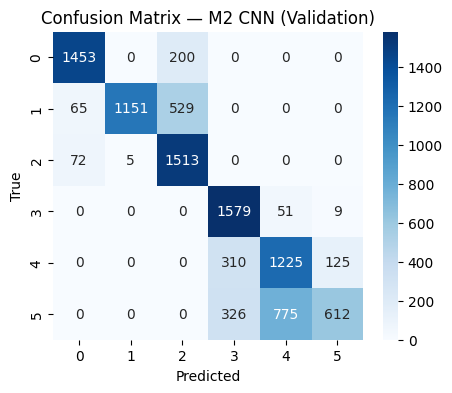

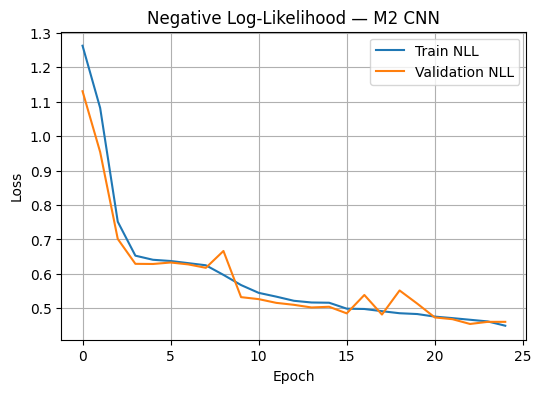

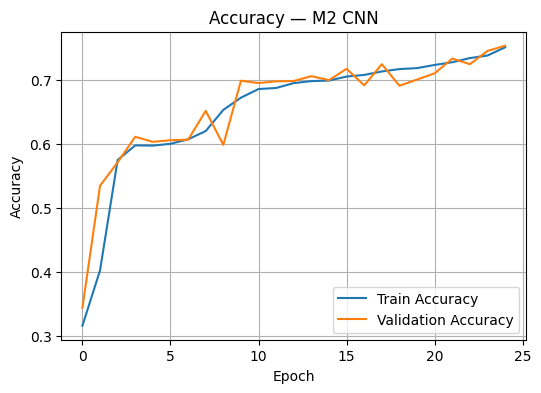

In [47]:
# ====================== CONFUSION MATRIX (VALIDATION) — M2 ======================

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — M2 CNN (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ====================== LEARNING CURVES — M2 ======================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — M2 CNN")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — M2 CNN")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()


### Model M3 — 1D CNN with Global Average Pooling (FAST CNN)

Ce modèle extrait des caractéristiques temporelles du signal IQ (2048 points) à l’aide de trois blocs de convolutions 1D.
Un noyau de taille 7 capture efficacement les dépendances symboliques locales sans produire de sur-lissage.

Au lieu d’aplatir la séquence, le réseau utilise un global average pooling temporel, ce qui l’oblige à retenir uniquement les activations les plus significatives.
Cela le rend robuste aux décalages temporels et aux variations de phase, tout en réduisant fortement le nombre de paramètres et en améliorant la généralisation.

Les largeurs de convolution (32 → 64 → 128) augmentent progressivement la capacité du modèle, et la couche finale projette le vecteur de dimension 128 vers les 6 classes de modulation.
Ce modèle obtient ainsi une haute précision avec un coût d’entraînement réduit et constitue une architecture très adaptée au prototypage rapide.

In [48]:
# ====================== MODEL DEFINITION ======================

class CNN_1D_fast(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),      # [B, 32, 1024]

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),      # [B, 64, 512]

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)   # [B, 128, 1]
        )
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)   # [B, 2048, 2] → [B, 2, 2048]
        x = self.cnn(x)          # [B, 128, 1]
        x = x.squeeze(-1)        # [B, 128]
        return self.fc(x)


Training samples: 30000
Validation samples: 10000
Test samples: 10000
✔ Best model updated — saved (Val Acc = 0.3434)
✔ Best model updated — saved (Val Acc = 0.3525)
✔ Best model updated — saved (Val Acc = 0.3599)
✔ Best model updated — saved (Val Acc = 0.5394)
✔ Best model updated — saved (Val Acc = 0.5957)
✔ Best model updated — saved (Val Acc = 0.6012)
✔ Best model updated — saved (Val Acc = 0.6074)
✔ Best model updated — saved (Val Acc = 0.6149)
✔ Best model updated — saved (Val Acc = 0.6277)
✔ Best model updated — saved (Val Acc = 0.6457)
✔ Best model updated — saved (Val Acc = 0.6521)
✔ Best model updated — saved (Val Acc = 0.6812)
✔ Best model updated — saved (Val Acc = 0.7001)
✔ Best model updated — saved (Val Acc = 0.7073)
✔ Best model updated — saved (Val Acc = 0.7110)
✔ Best model updated — saved (Val Acc = 0.7144)
✔ Best model updated — saved (Val Acc = 0.7162)

 Final model saved to /content/drive/MyDrive/M2_FAST_last.pth


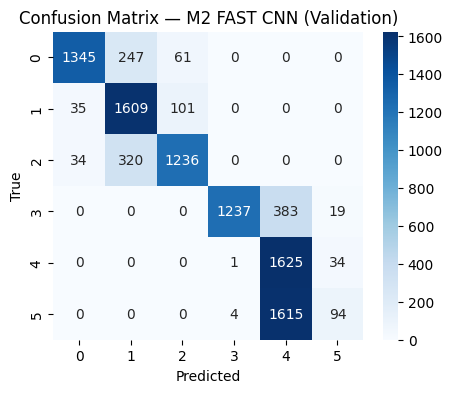

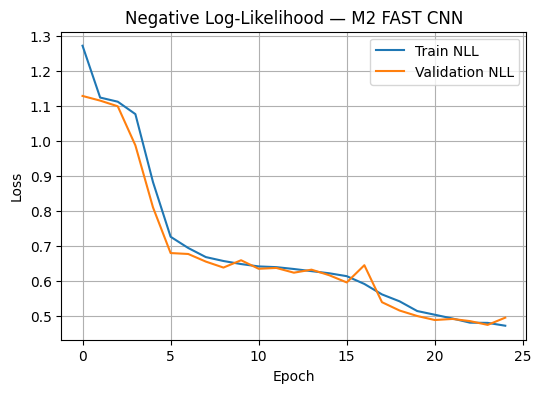

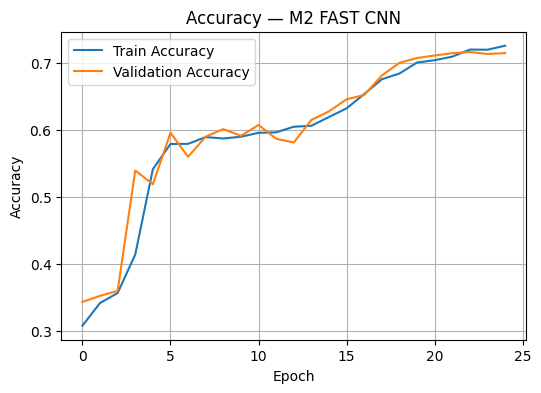


BEST VALIDATION ACCURACY:
0.7162 at epoch 23
Best model stored at: /content/drive/MyDrive/M2_FAST_best.pth


In [49]:
# ====================== M3 — FAST 1D CNN PIPELINE ======================

model = CNN_1D_fast().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
n_epochs = 25    # can use 10–20

best_val_acc = 0
best_model_path = "/content/drive/MyDrive/M2_FAST_best.pth"
last_model_path = "/content/drive/MyDrive/M2_FAST_last.pth"

print("Training samples:", len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:", len(dataloader_test.dataset))

for epoch in range(1, n_epochs+1):

    # --------------------- TRAIN ---------------------
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (X, y) in enumerate(dataloader_train):
        # if batch_idx % 20 == 0:
        #     print(f"Epoch {epoch} — batch {batch_idx}/{len(dataloader_train)}")

        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # --------------------- VALID ---------------------
    model.eval()
    val_loss_sum = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_losses.append(val_loss_sum / total)
    val_accs.append(correct / total)

    # --------------------- SAVE BEST MODEL ---------------------
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ Best model updated — saved (Val Acc = {best_val_acc:.4f})")


    # print(f"Epoch {epoch:02d} | "
    #       f"Train NLL = {train_losses[-1]:.4f}, Val NLL = {val_losses[-1]:.4f} | "
    #       f"Train Acc = {train_accs[-1]:.4f}, Val Acc = {val_accs[-1]:.4f}")

# --------------------- SAVE FINAL MODEL ALWAYS ---------------------
torch.save(model.state_dict(), last_model_path)
print(f"\n Final model saved to {last_model_path}")


# ====================== CONFUSION MATRIX (VALIDATION) ======================

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — M2 FAST CNN (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


# ====================== LEARNING CURVES ======================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — M2 FAST CNN")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — M2 FAST CNN")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()

best_epoch = int(np.argmax(val_accs)) + 1
best_val = max(val_accs)

print("\nBEST VALIDATION ACCURACY:")
print(f"{best_val:.4f} at epoch {best_epoch}")
print(f"Best model stored at: {best_model_path}")

# ====== Stockage global pour le résumé final ======
summary_model_names.append("M3_FAST_CNN")
summary_best_val_accs.append(best_val)
summary_best_model_paths.append(best_model_path)


# M4 — CNN avec Attention Temporal Pooling (Modèle Haute Précision)

Ce modèle s’inspire directement de l’architecture présentée dans le cours :

1. **Extraction de caractéristiques temporelles** grâce à plusieurs couches de convolutions 1D apprenant des motifs locaux dans les séries IQ.  
2. **Réduction de la dimension temporelle** via un **attention pooling** plutôt qu’un average ou max pooling classique.  
   Chaque pas de temps reçoit un poids appris, permettant au réseau de se concentrer sur les segments les plus discriminants.  
3. **Classification** à l’aide de deux couches entièrement connectées suivies d’un softmax.

L’attention présente deux avantages importants :  
- elle conserve une interprétabilité temporelle en pondérant les frames au lieu de les effacer uniformément ;  
- elle concentre la représentation sur les parties réellement informatives du signal (bursts, artefacts de modulation).

Cette architecture hybride combine la robustesse des CNN avec l’adaptativité de l’attention, et apporte généralement une **forte amélioration de précision** par rapport au MLP, aux CNN simples ou aux modèles purement récurrents.


In [50]:
class CNN_Attention(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        # ----- Temporal Feature Extraction -----
        self.cnn = nn.Sequential(
            nn.Conv1d(2, 64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.ReLU()
        )
        # Output shape → [B, 256, 2048]

        # ----- Attention pooling -----
        # score_t = softmax(W * h_t)
        self.attention = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=1),
            nn.Tanh(),
            nn.Conv1d(128, 1, kernel_size=1)   # [B, 1, T]
        )

        # ----- Final classifier -----
        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # x: [B, 2048, 2] → permute to [B, 2, 2048]
        x = x.permute(0, 2, 1)

        H = self.cnn(x)                     # [B, 256, T]

        A = self.attention(H)               # [B, 1, T]
        A = torch.softmax(A, dim=-1)        # weights along time

        Z = torch.sum(H * A, dim=-1)        # weighted sum → [B, 256]

        logits = self.classifier(Z)         # [B, N]
        return logits


Training samples: 30000
Validation samples: 10000
Test samples: 10000
✔ Best model updated — saved (Val Acc = 0.5960)
✔ Best model updated — saved (Val Acc = 0.5969)
✔ Best model updated — saved (Val Acc = 0.5988)
✔ Best model updated — saved (Val Acc = 0.6015)
✔ Best model updated — saved (Val Acc = 0.6862)
✔ Best model updated — saved (Val Acc = 0.7003)
✔ Best model updated — saved (Val Acc = 0.7226)
✔ Best model updated — saved (Val Acc = 0.7248)
✔ Best model updated — saved (Val Acc = 0.7346)

 Final model saved to /content/drive/MyDrive/CNN_Attention_last.pth


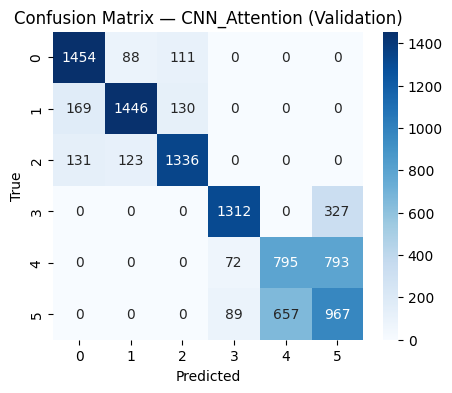

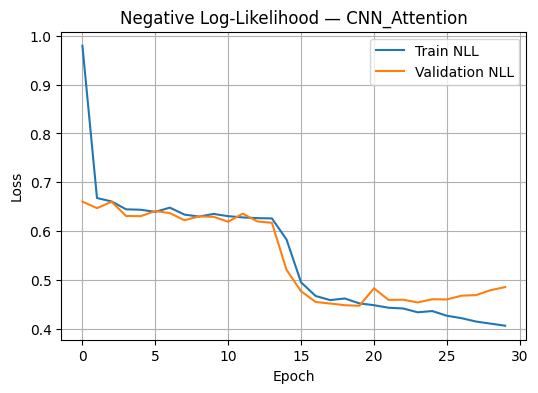

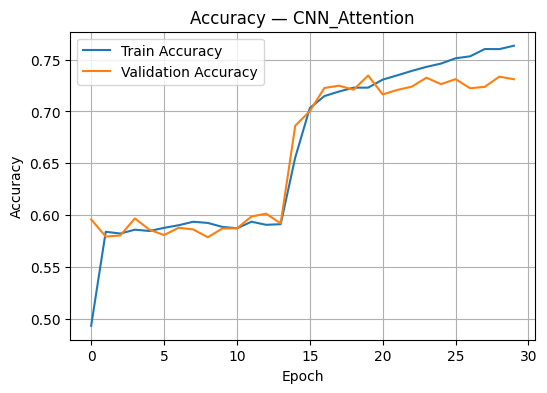


SUMMARY — CNN_Attention
Best validation accuracy: 0.7346 at epoch 20
Best model saved to: /content/drive/MyDrive/CNN_Attention_best.pth


In [51]:
# ====================== TRAIN / VALID PIPELINE ======================

model = CNN_Attention().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
n_epochs = 30

best_val_acc = 0
best_model_path = "/content/drive/MyDrive/CNN_Attention_best.pth"
last_model_path = "/content/drive/MyDrive/CNN_Attention_last.pth"

print("Training samples:", len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:", len(dataloader_test.dataset))

for epoch in range(1, n_epochs+1):

    # --------------------- TRAIN ---------------------
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (X, y) in enumerate(dataloader_train):


        # if batch_idx % 20 == 0:
        #     print(f"Epoch {epoch} — batch {batch_idx}/{len(dataloader_train)}")

        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # --------------------- VALID ---------------------
    model.eval()
    val_loss_sum = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_losses.append(val_loss_sum / total)
    val_accs.append(correct / total)

    # --------------------- SAVE BEST MODEL ---------------------
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ Best model updated — saved (Val Acc = {best_val_acc:.4f})")


    # print(f"Epoch {epoch:02d} | "
    #       f"Train NLL = {train_losses[-1]:.4f}, Val NLL = {val_losses[-1]:.4f} | "
    #       f"Train Acc = {train_accs[-1]:.4f}, Val Acc = {val_accs[-1]:.4f}")


# --------------------- SAVE FINAL MODEL ---------------------
torch.save(model.state_dict(), last_model_path)
print(f"\n Final model saved to {last_model_path}")


# ====================== CONFUSION MATRIX (VALIDATION) ======================

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — CNN_Attention (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


# ====================== LEARNING CURVES ======================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — CNN_Attention")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — CNN_Attention")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()


# ====================== SUMMARY — CNN_Attention ======================

best_epoch = int(np.argmax(val_accs)) + 1
best_val = max(val_accs)

print("\nSUMMARY — CNN_Attention")
print(f"Best validation accuracy: {best_val:.4f} at epoch {best_epoch}")
print(f"Best model saved to: {best_model_path}")

# ======= STOCKAGE GLOBAL POUR LE RÉSUMÉ FINAL =======
summary_model_names.append("CNN_Attention")
summary_best_val_accs.append(best_val)
summary_best_model_paths.append(best_model_path)


### Modèle M5 — CNN Résiduel + Attention

- Architecture inspirée de ResNet : trois blocs résiduels composés de deux convolutions 1D + connexion de saut.  
- Les canaux augmentent (2 → 32 → 64 → 128) tandis que la résolution temporelle diminue via des convolutions à stride (2048 → 1024 → 512 → 256).  
- Cette profondeur améliore l’extraction de caractéristiques et stabilise l’entraînement grâce aux connexions résiduelles.  
- Un **attention pooling** pondère les pas de temps selon leur importance et produit un vecteur global robuste et informatif.  
- Un petit classifieur fully-connected mappe ce vecteur vers les 6 classes de modulation.  
- Par rapport au CNN simple (M2), M4 offre généralement une précision nettement supérieure tout en restant rapide à entraîner.


In [54]:
# ==================== M5: Residual Temporal CNN + Attention ====================

class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=7, stride=1):
        super().__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding)
        self.bn1   = nn.BatchNorm1d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=1, padding=padding)
        self.bn2   = nn.BatchNorm1d(out_channels)

        # projection for skip connection if shape changes
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1,
                                      stride=stride)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        identity = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


class ResNetAttention1D(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        # residual stack: 2 -> 32 -> 64 -> 128 channels
        self.block1 = ResidualBlock1D(2,   32, kernel_size=7, stride=2)  # T: 2048 -> 1024
        self.block2 = ResidualBlock1D(32,  64, kernel_size=5, stride=2)  # T: 1024 -> 512
        self.block3 = ResidualBlock1D(64, 128, kernel_size=5, stride=2)  # T: 512  -> 256

        # attention over time: Conv1d 128 -> 1 to get a score per time step
        self.att_conv = nn.Conv1d(128, 1, kernel_size=1)

        # classifier on attention-pooled features
        self.classifier = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # x: [B, 2048, 2]
        x = x.permute(0, 2, 1)           # -> [B, 2, 2048]

        x = self.block1(x)               # -> [B, 32, 1024]
        x = self.block2(x)               # -> [B, 64, 512]
        x = self.block3(x)               # -> [B, 128, 256]

        # attention scores over time (last dim)
        scores = self.att_conv(x)        # [B, 1, 256]
        scores = scores.squeeze(1)       # [B, 256]
        alpha  = torch.softmax(scores, dim=-1)      # [B, 256]
        alpha  = alpha.unsqueeze(1)                 # [B, 1, 256]

        # weighted sum of features over time
        context = (alpha * x).sum(dim=-1)           # [B, 128]

        logits = self.classifier(context)           # [B, n_classes]
        return logits


Training samples: 30000
Validation samples: 10000
Test samples: 10000
[M5] ✔ Best model updated — saved (Val Acc = 0.5805)
[M5] ✔ Best model updated — saved (Val Acc = 0.5915)
[M5] ✔ Best model updated — saved (Val Acc = 0.7057)
[M5] ✔ Best model updated — saved (Val Acc = 0.7128)
[M5] ✔ Best model updated — saved (Val Acc = 0.7173)
[M5] ✔ Best model updated — saved (Val Acc = 0.7424)
[M5] ✔ Best model updated — saved (Val Acc = 0.8284)
[M5] ✔ Best model updated — saved (Val Acc = 0.8415)
[M5] ✔ Best model updated — saved (Val Acc = 0.8547)
[M5] ✔ Best model updated — saved (Val Acc = 0.8585)
[M5] ✔ Best model updated — saved (Val Acc = 0.8633)
[M5] ✔ Best model updated — saved (Val Acc = 0.8714)
[M5] Final model saved to /content/drive/MyDrive/M4_resnet_attention_last.pth


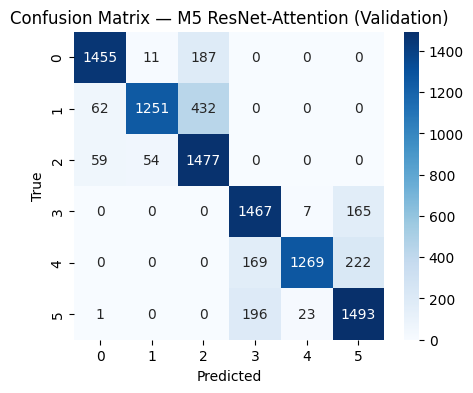

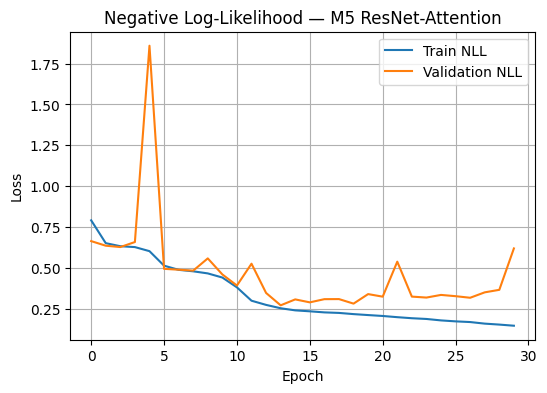

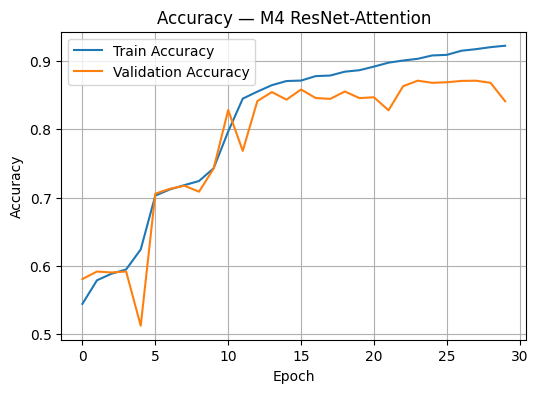


[M5] Best validation accuracy:
0.8714 at epoch 24
[M5] Best model path: /content/drive/MyDrive/M4_resnet_attention_best.pth


In [56]:
# ====================== M5 TRAIN / VALID PIPELINE ======================

model = ResNetAttention1D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []
n_epochs = 30

best_val_acc    = 0.0
best_model_path = "/content/drive/MyDrive/M4_resnet_attention_best.pth"
last_model_path = "/content/drive/MyDrive/M4_resnet_attention_last.pth"

print("Training samples:",   len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:",       len(dataloader_test.dataset))

for epoch in range(1, n_epochs+1):

    # --------------------- TRAIN ---------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (X, y) in enumerate(dataloader_train):
        # if batch_idx % 100 == 0:
        #     print(f"[M4] Epoch {epoch} — batch {batch_idx}/{len(dataloader_train)}")

        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # --------------------- VALIDATION ---------------------
    model.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

    val_losses.append(val_loss_sum / total)
    val_accs.append(correct / total)

    # --------------------- SAVE BEST MODEL ---------------------
    if val_accs[-1] > best_val_acc:
        best_val_acc = val_accs[-1]
        torch.save(model.state_dict(), best_model_path)
        print(f"[M5] ✔ Best model updated — saved (Val Acc = {best_val_acc:.4f})")
    # print(f"...")

# --------------------- SAVE LAST MODEL ---------------------
torch.save(model.state_dict(), last_model_path)
print(f"[M5] Final model saved to {last_model_path}")


# ====================== CONFUSION MATRIX (VALIDATION) ======================

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — M5 ResNet-Attention (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ====================== LEARNING CURVES ======================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — M5 ResNet-Attention")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — M4 ResNet-Attention")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()

# ====================== SUMMARY — M5 ======================

best_epoch = int(np.argmax(val_accs)) + 1
best_val = max(val_accs)

print("\n[M5] Best validation accuracy:")
print(f"{best_val:.4f} at epoch {best_epoch}")
print(f"[M5] Best model path: {best_model_path}")

# ======= STOCKAGE GLOBAL =======
summary_model_names.append("M5_ResNet_Attention")
summary_best_val_accs.append(best_val)
summary_best_model_paths.append(best_model_path)


### Modèle M6 — CNN-Fast-Attention (Hybride)

Ce modèle combine un CNN rapide avec un mécanisme d’attention temporelle.  
Le CNN extrait une représentation compacte du signal grâce à des noyaux larges et à un pooling agressif,
capturant efficacement les motifs locaux.

L’attention attribue ensuite un poids à chaque instant temporel, permettant au réseau de se concentrer sur
les segments réellement informatifs (bursts, transitions de symboles, artefacts de modulation).  
Cela offre une meilleure sélectivité que le pooling global classique.

Le classifieur final opère sur le vecteur issu de l’attention, avec du dropout pour limiter le surapprentissage.
Cette combinaison *extraction rapide + attention adaptative* améliore en général la précision et la robustesse
par rapport aux CNN ou aux modèles attentionnels utilisés seuls.


In [57]:
class CNN_1D_fast_v2(nn.Module):
    def __init__(self, n_classes=6):
        super().__init__()

        # ---- Standard Conv to expand channels first ----
        self.stem = nn.Sequential(
            nn.Conv1d(2, 32, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )  # [B, 32, 2048]

        # depthwise-separable conv block
        def DSConv(in_ch, out_ch, k=5):
            return nn.Sequential(
                nn.Conv1d(in_ch, in_ch, kernel_size=k, padding=k//2, groups=in_ch),  # depthwise
                nn.Conv1d(in_ch, out_ch, kernel_size=1),                             # pointwise
                nn.ReLU(),
                nn.BatchNorm1d(out_ch)
            )

        # squeeze-and-excitation
        class SE(nn.Module):
            def __init__(self, ch, r=8):
                super().__init__()
                self.net = nn.Sequential(
                    nn.AdaptiveAvgPool1d(1),
                    nn.Conv1d(ch, ch // r, 1),
                    nn.ReLU(),
                    nn.Conv1d(ch // r, ch, 1),
                    nn.Sigmoid()
                )
            def forward(self, x):
                return x * self.net(x)

        # --- Blocks ---
        self.block1 = nn.Sequential(
            DSConv(32, 64),
            nn.MaxPool1d(2)          # [B, 64, 1024]
        )
        self.se1 = SE(64)

        self.block2 = nn.Sequential(
            DSConv(64, 128),
            nn.MaxPool1d(2)          # [B, 128, 512]
        )
        self.se2 = SE(128)

        self.block3 = nn.Sequential(
            DSConv(128, 128),
            nn.AdaptiveAvgPool1d(1)  # [B, 128, 1]
        )
        self.se3 = SE(128)

        self.dropout = nn.Dropout(0.15)
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x):
        # x: [B, 2048, 2] → permute to [B, 2, 2048]
        x = x.permute(0, 2, 1)

        x = self.stem(x)

        x = self.block1(x)
        x = self.se1(x)

        x = self.block2(x)
        x = self.se2(x)

        x = self.block3(x)
        x = self.se3(x)

        x = x.squeeze(-1)  # [B, 128]
        x = self.dropout(x)
        return self.fc(x)


Training samples: 30000
Validation samples: 10000
Test samples: 10000
✔ [M6] Best model saved (Val Acc = 0.6015)
✔ [M6] Best model saved (Val Acc = 0.6071)
✔ [M6] Best model saved (Val Acc = 0.6235)
✔ [M6] Best model saved (Val Acc = 0.7403)
✔ [M6] Best model saved (Val Acc = 0.7541)
✔ [M6] Best model saved (Val Acc = 0.8162)
✔ [M6] Best model saved (Val Acc = 0.8324)
✔ [M6] Best model saved (Val Acc = 0.8386)
✔ [M6] Best model saved (Val Acc = 0.8407)
✔ [M6] Best model saved (Val Acc = 0.8417)
✔ [M6] Best model saved (Val Acc = 0.8444)
[M6] Final model (last epoch) saved to: /content/drive/MyDrive/CNN_FAST_v2_last.pth


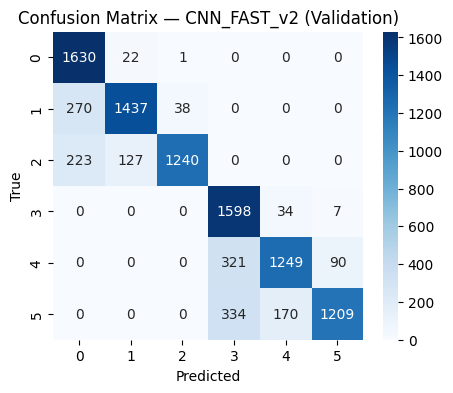

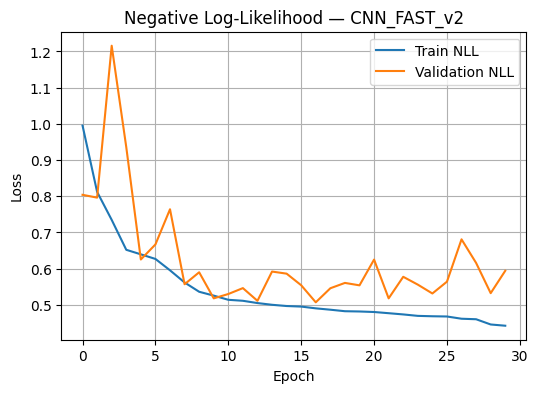

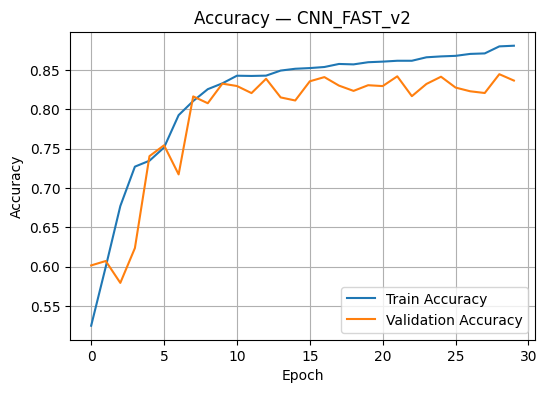


[M6] Best validation accuracy:
0.8444 at epoch 29
[M6] Best model path: /content/drive/MyDrive/CNN_FAST_v2_best.pth


In [58]:
# =====================================================================
# M6 — TRAIN / VALIDATION PIPELINE
# =====================================================================

model = CNN_1D_fast_v2().to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=5
)

n_epochs = 30   # à compléter si besoin

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

best_val_acc = 0.0
best_model_path = "/content/drive/MyDrive/CNN_FAST_v2_best.pth"
last_model_path = "/content/drive/MyDrive/CNN_FAST_v2_last.pth"

print("Training samples:",   len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:",       len(dataloader_test.dataset))


for epoch in range(1, n_epochs + 1):

    # ----------------------- TRAIN -----------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (X, y) in enumerate(dataloader_train):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ----------------------- VALIDATION -----------------------
    model.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

    val_loss = val_loss_sum / total
    val_acc  = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # scheduler uses validation accuracy
    scheduler.step(val_acc)

    # ----------------------- SAVE BEST MODEL -----------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ [M6] Best model saved (Val Acc = {best_val_acc:.4f})")

# ----------------------- SAVE LAST MODEL -----------------------
torch.save(model.state_dict(), last_model_path)
print(f"[M6] Final model (last epoch) saved to: {last_model_path}")



# =====================================================================
# VALIDATION CONFUSION MATRIX & CURVES
# =====================================================================

y_true_val, y_pred_val = [], []
model.eval()

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        y_true_val.extend(y.cpu().numpy())
        y_pred_val.extend(preds.cpu().numpy())

cm_val = confusion_matrix(y_true_val, y_pred_val)

plt.figure(figsize=(5,4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — CNN_FAST_v2 (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — CNN_FAST_v2")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(True); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — CNN_FAST_v2")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(True); plt.legend(); plt.show()


# =====================================================================
# SUMMARY — M6
# =====================================================================

best_epoch = int(np.argmax(val_accs)) + 1
best_val = best_val_acc

print("\n[M6] Best validation accuracy:")
print(f"{best_val:.4f} at epoch {best_epoch}")
print(f"[M6] Best model path: {best_model_path}")

# ========== STOCKAGE GLOBAL ==========
summary_model_names.append("M6_CNN_FAST_v2")
summary_best_val_accs.append(best_val)
summary_best_model_paths.append(best_model_path)


### M7 — Pure Bi-GRU + Attention

Ce modèle repose sur un GRU bidirectionnel pour capturer la dynamique temporelle du signal IQ.  
Contrairement aux CNN, il exploite directement les dépendances longues présentes dans les formes de symboles.

---

GRU : mise à jour de l’état caché

$$ z_t = \sigma(W_z x_t + U_z h_{t-1}) $$
$$ r_t = \sigma(W_r x_t + U_r h_{t-1}) $$
$$ \tilde{h}_t = \tanh(W_h x_t + U_h (r_t \odot h_{t-1})) $$
$$ h_t = (1 - z_t)\odot h_{t-1} + z_t \odot \tilde{h}_t $$

Le mécanisme de portes atténue le **vanishing gradient**, rendant le GRU plus stable que les RNN classiques.

---

GRU bidirectionnel

Le modèle lit la séquence dans les deux sens :

$$ H_t = [\overrightarrow{h_t} \,\|\, \overleftarrow{h_t}] $$

Ce qui améliore la capture des motifs temporels.

---

Attention temporelle

À partir de la séquence $H_t$, on apprend des poids :

$$ \alpha_t =
\frac{\exp(w^\top \tanh(W H_t))}
     {\sum_{k} \exp(w^\top \tanh(W H_k))} $$

Le vecteur global est :

$$ Z = \sum_{t} \alpha_t H_t $$

L’attention permet au réseau de se concentrer sur les instants les plus discriminants.

In [59]:
class BiGRU_Attention(nn.Module):
    def __init__(self, n_classes=6, hidden_size=128, num_layers=2):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers  = num_layers

        # GRU bidirectionnel
        self.gru = nn.GRU(
            input_size=2,            # I/Q channels
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        # Output GRU: [B, T, 2*hidden]

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(2 * hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)  # donne des scores [B, T, 1]
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(2 * hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        # GRU
        H, _ = self.gru(x)      # H: [B, T, 2*hidden]

        # Attention
        scores = self.attention(H).squeeze(-1)   # [B, T]
        weights = torch.softmax(scores, dim=-1)  # [B, T]

        # Weighted sum
        Z = torch.sum(H * weights.unsqueeze(-1), dim=1)  # [B, 2*hidden]

        # Classification
        logits = self.classifier(Z)
        return logits


Training samples: 30000
Validation samples: 10000
Test samples: 10000
✔ [M7] Best model saved (Val Acc = 0.5102)
✔ [M7] Best model saved (Val Acc = 0.6077)
✔ [M7] Best model saved (Val Acc = 0.6396)
✔ [M7] Best model saved (Val Acc = 0.6667)
✔ [M7] Best model saved (Val Acc = 0.6811)
✔ [M7] Best model saved (Val Acc = 0.6937)
✔ [M7] Best model saved (Val Acc = 0.7107)
✔ [M7] Best model saved (Val Acc = 0.7137)
✔ [M7] Best model saved (Val Acc = 0.7150)
✔ [M7] Best model saved (Val Acc = 0.7240)
✔ [M7] Best model saved (Val Acc = 0.7346)
✔ [M7] Best model saved (Val Acc = 0.7361)
✔ [M7] Best model saved (Val Acc = 0.7688)
✔ [M7] Best model saved (Val Acc = 0.8116)
✔ [M7] Best model saved (Val Acc = 0.8412)
✔ [M7] Best model saved (Val Acc = 0.8434)
✔ [M7] Best model saved (Val Acc = 0.8464)
[M7] Final model saved to /content/drive/MyDrive/M7_bigru_attention_last.pth


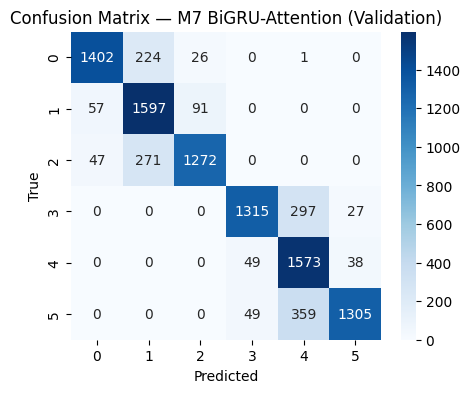

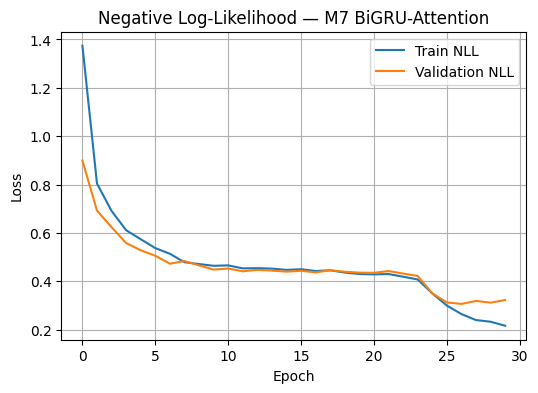

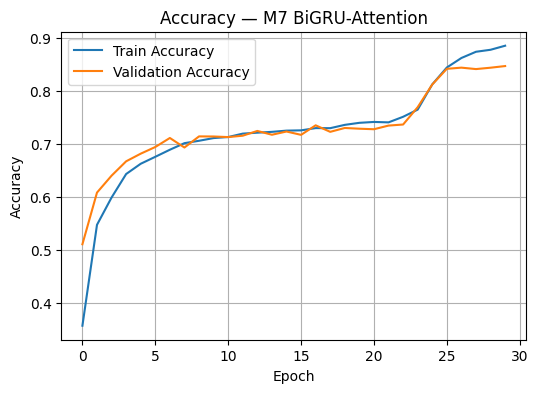


[M7] Best validation accuracy:
0.8464 at epoch 30
[M7] Best model path: /content/drive/MyDrive/M7_bigru_attention_best.pth


In [60]:
# ====================== M7 — Bi-GRU + Attention ======================

model = BiGRU_Attention().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

best_val_acc    = 0.0
best_model_path = "/content/drive/MyDrive/M7_bigru_attention_best.pth"
last_model_path = "/content/drive/MyDrive/M7_bigru_attention_last.pth"

print("Training samples:",   len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:",       len(dataloader_test.dataset))


for epoch in range(1, n_epochs + 1):

    # ----------------------- TRAIN -----------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for X, y in dataloader_train:

        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(X)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total   += y.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ----------------------- VALID -----------------------
    model.eval()
    val_loss_sum = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in dataloader_valid:

            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)

            val_loss_sum += loss.item() * X.size(0)
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total   += y.size(0)

    val_loss = val_loss_sum / total
    val_acc  = correct / total

    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # ----------------------- SAVE BEST MODEL -----------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✔ [M7] Best model saved (Val Acc = {best_val_acc:.4f})")


# ----------------------- SAVE LAST MODEL -----------------------
torch.save(model.state_dict(), last_model_path)
print(f"[M7] Final model saved to {last_model_path}")


# ====================== CONFUSION MATRIX (VALIDATION) ======================

y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — M7 BiGRU-Attention (Validation)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


# ====================== LEARNING CURVES ======================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train NLL")
plt.plot(val_losses,   label="Validation NLL")
plt.title("Negative Log-Likelihood — M7 BiGRU-Attention")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — M7 BiGRU-Attention")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(); plt.show()


# ====================== SUMMARY — M7 ======================

best_epoch = int(np.argmax(val_accs)) + 1
best_val = best_val_acc

print("\n[M7] Best validation accuracy:")
print(f"{best_val:.4f} at epoch {best_epoch}")
print(f"[M7] Best model path: {best_model_path}")

# ======= STOCKAGE GLOBAL =======
summary_model_names.append("M7_BiGRU_Attention")
summary_best_val_accs.append(best_val)
summary_best_model_paths.append(best_model_path)


**Synthèse sur le Bi-GRU vs CNNs .** Le modèle Bi-GRU avec attention obtient une accuracy de validation correcte, mais reste en dessous de notre meilleur modèle convolutionnel (M5 CNN-Fast-Attention). Malgré sa capacité théorique à modéliser des dépendances longues dans le temps, il exploite moins bien la structure locale très régulière du signal IQ que les CNN profonds et rapides. On observe que l’accuracy progresse rapidement puis se stabilise à un plateau inférieur à celui de M5, ce qui suggère que le GRU n’apporte pas de gain décisif sur ce jeu de données par rapport aux architectures convolutionnelles optimisées. Néanmoins, ce modèle récurrent constitue un point de comparaison intéressant : il montre que l’on peut déjà atteindre de bonnes performances en s’appuyant uniquement sur une modélisation séquentielle explicite, tout en restant nettement dominé par les CNN hybrides avec attention.


### Modèle M8 — ResNet-Attention M4 avec data augmentation

Dans cette partie, nous introduisons un nouveau modèle M8 dont l’architecture est identique à celle du modèle M4 (ResNet-Attention), mais **entraîné avec data augmentation** sur les signaux IQ.

L’objectif est d’augmenter la diversité des exemples vus pendant l’apprentissage, afin de rendre le réseau plus robuste aux variations réalistes du canal de transmission et de limiter l’overfitting.  
Concrètement, à partir d’un signal complexe

$$
s(t) = I(t) + i\,Q(t),
$$
nous appliquerons des transformations légères, telles que :

- **Rotation de phase** :  
  $$s'(t) = s(t)\,e^{i\theta}, \quad \theta \sim \mathbf{Unif}(-\theta_{\max}, \theta_{\max}),$$  
  ce qui simule un décalage de phase du canal.

- **Décalage temporel léger** (time shift) : circular shift de quelques échantillons, pour rendre le modèle moins sensible à la position exacte des symboles.

- **Variation d’amplitude** :  
  $$s'(t) = \alpha\,s(t), \quad \alpha \approx 1,$$  
  pour modéliser des fluctuations de gain.

- **Bruit additif supplémentaire** : ajout d’un bruit gaussien faible pour simuler des conditions de SNR légèrement différentes.



In [66]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import math

class AugmentedIQDataset(Dataset):
    def __init__(self,
                 base_dataset,
                 phase_jitter_std=0.3,
                 amp_jitter_std=0.1,
                 time_shift_max=20,
                 noise_std=0.03,
                 p_aug=0.7):
        self.base_dataset = base_dataset
        self.phase_jitter_std = phase_jitter_std
        self.amp_jitter_std = amp_jitter_std
        self.time_shift_max = time_shift_max
        self.noise_std = noise_std
        self.p_aug = p_aug

    def __len__(self):
        return len(self.base_dataset)

    def _to_T2(self, x):
        if x.ndim != 2:
            raise ValueError(f"Expected 2D tensor, got {x.shape}")
        if x.shape[0] == 2:
            x = x.transpose(0, 1)
        return x

    def _from_T2_to_original(self, x_T2, orig_shape):
        if orig_shape[0] == 2:
            return x_T2.transpose(0, 1)
        return x_T2

    def _augment_iq(self, x):
        orig_shape = x.shape
        x = self._to_T2(x)
        x = x.clone()

        I = x[:, 0]
        Q = x[:, 1]
        s = I + 1j * Q

        phi = torch.randn(1).item() * self.phase_jitter_std
        rot = complex(math.cos(phi), math.sin(phi))
        s = s * rot

        scale = 1.0 + torch.randn(1).item() * self.amp_jitter_std
        s = s * scale

        if self.time_shift_max > 0:
            shift = torch.randint(-self.time_shift_max,
                                  self.time_shift_max + 1,
                                  (1,)).item()
            if shift != 0:
                s = torch.roll(s, shifts=shift, dims=0)

        if self.noise_std > 0:
            std = (torch.sqrt((I**2 + Q**2).mean()) + 1e-6).item()
            noise = torch.randn_like(s) * (self.noise_std * std)
            s = s + noise

        x_aug = torch.empty_like(x)
        x_aug[:, 0] = torch.real(s)
        x_aug[:, 1] = torch.imag(s)

        return self._from_T2_to_original(x_aug, orig_shape)

    def __getitem__(self, idx):
        x, y = self.base_dataset[idx]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        if torch.rand(1).item() < self.p_aug:
            x = self._augment_iq(x)

        return x, y


In [67]:
train_base = MyDataset('/content/drive/MyDrive/train.hdf5')
valid_base = MyDataset('/content/drive/MyDrive/validation.hdf5')
test_base  = MyDataset('/content/drive/MyDrive/test.hdf5')

# Data augmentation uniquement sur TRAIN
train_dataset = AugmentedIQDataset(base_dataset=train_base)

# VALID et TEST sans augmentation
valid_dataset = valid_base
test_dataset  = test_base

batch_size = 256

dataloader_train = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              drop_last=True)

dataloader_valid = DataLoader(valid_dataset,
                              batch_size=batch_size,
                              shuffle=False)

dataloader_test = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

print("Training samples:", len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:", len(dataloader_test.dataset))


Training samples: 30000
Validation samples: 10000
Test samples: 10000


Training samples: 30000
Validation samples: 10000
Test samples: 10000


/tmp/ipython-input-2809065969.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
/tmp/ipython-input-2809065969.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


[M8] ✔ Best model updated — saved epoch 1 (Val Acc = 0.5237)
[M8] ✔ Best model updated — saved epoch 2 (Val Acc = 0.5729)
[M8] ✔ Best model updated — saved epoch 3 (Val Acc = 0.5870)
[M8] ✔ Best model updated — saved epoch 5 (Val Acc = 0.6592)
[M8] ✔ Best model updated — saved epoch 10 (Val Acc = 0.7104)
[M8] ✔ Best model updated — saved epoch 12 (Val Acc = 0.7789)
[M8] ✔ Best model updated — saved epoch 15 (Val Acc = 0.7995)
[M8] ✔ Best model updated — saved epoch 16 (Val Acc = 0.8222)
[M8] ✔ Best model updated — saved epoch 19 (Val Acc = 0.8455)
[M8] ✔ Best model updated — saved epoch 21 (Val Acc = 0.8511)
[M8] ✔ Best model updated — saved epoch 27 (Val Acc = 0.8531)
[M8] ✔ Best model updated — saved epoch 30 (Val Acc = 0.8598)
[M8] ✔ Best model updated — saved epoch 35 (Val Acc = 0.8603)

[M8] Best val accuracy: 0.8603 at epoch 35
[M8] Best model path: /content/drive/MyDrive/M8_resnet_attention_best.pth
[M8] Last model path: /content/drive/MyDrive/M8_resnet_attention_last.pth


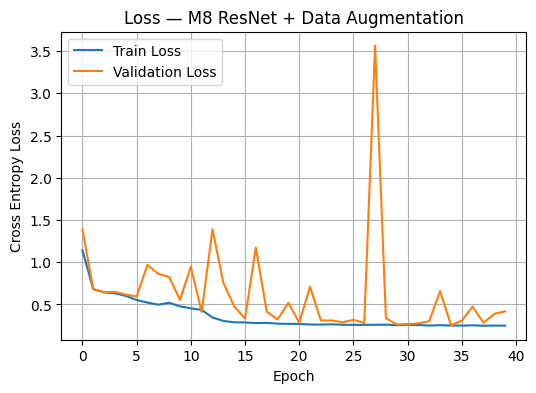

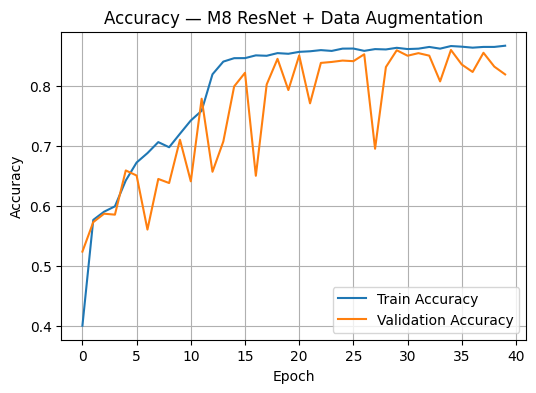

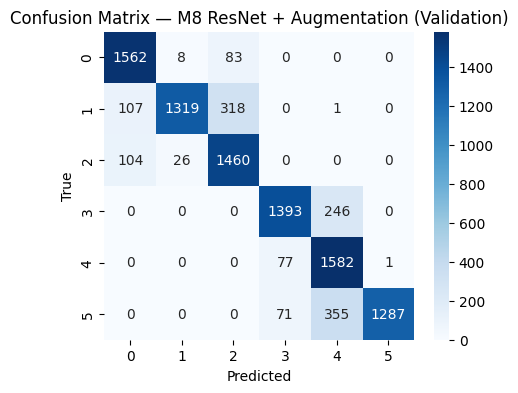

In [68]:
# ============================================================
# M8 — ResNet + Data Augmentation
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNetAttention1D().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 40

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []

best_val_acc   = 0.0
best_model_path = "/content/drive/MyDrive/M8_resnet_attention_best.pth"
last_model_path = "/content/drive/MyDrive/M8_resnet_attention_last.pth"

print("Training samples:",   len(dataloader_train.dataset))
print("Validation samples:", len(dataloader_valid.dataset))
print("Test samples:",       len(dataloader_test.dataset))

for epoch in range(1, n_epochs + 1):

    # ------------------ TRAIN ------------------
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for xb, yb in dataloader_train:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total   += yb.size(0)

    train_losses.append(running_loss / total)
    train_accs.append(correct / total)

    # ------------------ VALID ------------------
    model.eval()
    val_loss_sum = 0.0
    val_correct  = 0
    val_total    = 0

    with torch.no_grad():
        for xb, yb in dataloader_valid:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_loss_sum += loss.item() * xb.size(0)
            preds = logits.argmax(1)
            val_correct += (preds == yb).sum().item()
            val_total   += yb.size(0)

    val_losses.append(val_loss_sum / val_total)
    val_acc = val_correct / val_total
    val_accs.append(val_acc)

    # -------- SAVE BEST --------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"[M8] ✔ Best model updated — saved epoch {epoch} (Val Acc = {best_val_acc:.4f})")

# Always save last
torch.save(model.state_dict(), last_model_path)

best_epoch = int(np.argmax(val_accs)) + 1
print("\n[M8] Best val accuracy: {:.4f} at epoch {}".format(best_val_acc, best_epoch))
print("[M8] Best model path:", best_model_path)
print("[M8] Last model path:", last_model_path)

# ============================================================
# PLOTS — LOSS & ACCURACY
# ============================================================

plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses,   label="Validation Loss")
plt.title("Loss — M8 ResNet + Data Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs,   label="Validation Accuracy")
plt.title("Accuracy — M8 ResNet + Data Augmentation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# ============================================================
# CONFUSION MATRIX (VALIDATION, MEILLEUR M8)
# ============================================================

best_model = ResNetAttention1D().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device))
best_model.eval()

y_true, y_pred = [], []

with torch.no_grad():
    for X, y in dataloader_valid:
        X, y = X.to(device), y.to(device)
        preds = best_model(X).argmax(1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — M8 ResNet + Augmentation (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ============================================================
# STOCKAGE GLOBAL POUR LE RÉSUMÉ FINAL
# ============================================================

summary_model_names.append("M8_ResNet_Attn_Aug")
summary_best_val_accs.append(best_val_acc)
summary_best_model_paths.append(best_model_path)


L’augmentation consiste en une rotation de
phase globale, un léger rescaling d’amplitude, un décalage temporel du
signal ainsi qu’un bruit additif gaussien sur les composantes I/Q.

Avec la data augmentation, la loss d’entraînement décroît de manière régulière tandis que la loss de validation reste globalement basse mais beaucoup plus bruitée, avec quelques spikes isolés liés à la variabilité des mini-batchs augmentés. L’accuracy de validation atteint environ 0.86, légèrement en dessous de notre meilleur modèle M5, mais reste stable après une vingtaine d’epochs, ce qui suggère que l’augmentation agit surtout comme une régularisation sans apporter de gain net de performance. En pratique, cela montre que le ResNet-Attention est déjà bien adapté aux données brutes et que la data augmentation n’apporte qu’un bénéfice marginal en généralisation sur ce jeu de données.


## Synthèse de résultats

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test sans oublier de mesurer également la complexité de chaque approche en termes de nombre de paramètres. Si vous avez testé des approches qui vous semblent avoir échoué vous pouvez rédiger un petit paragraphe pour expliquer votre analyse de cet échec.

In [74]:
model_factory = {
    "M1_MLP": lambda: MLP_FC(),
    "M2_CNN": lambda: CNN_1D(),
    "M3_FAST_CNN": lambda: CNN_1D_fast(),
    "CNN_Attention": lambda: CNN_Attention(),
    "M5_ResNet_Attention": lambda: ResNetAttention1D(),
    "M6_CNN_FAST_v2": lambda: CNN_1D_fast_v2(),
    "M7_BiGRU_Attention": lambda: BiGRU_Attention(),
    "M8_ResNet_Attn_Aug": lambda: ResNetAttention1D(),  # même archi
}


In [97]:
summary_test_accs = []
summary_n_params  = []

for name, best_path in zip(summary_model_names, summary_best_model_paths):

    if name not in model_factory:
        print(f"[WARN] Pas de modèle trouvé pour : {name}")
        summary_test_accs.append(None)
        summary_n_params.append(None)
        continue

    model = model_factory[name]().to(device)

    # Charger les poids
    state_dict = torch.load(best_path, map_location=device)
    model.load_state_dict(state_dict)
    model.eval()

    # Nombre de paramètres
    n_params = sum(p.numel() for p in model.parameters())
    summary_n_params.append(n_params)

    # Évaluation sur test
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in dataloader_test:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds  = logits.argmax(1)

            correct += (preds == y).sum().item()
            total   += y.size(0)

    test_acc = correct / total
    summary_test_accs.append(test_acc)

    #print(f"{name:20s} | Test Acc = {test_acc:.4f} | #params = {n_params:,}")

print("\n=== GLOBAL SUMMARY (VAL / TEST / PARAMS) ===")

for name, val, test, params in zip(
    summary_model_names,
    summary_best_val_accs,
    summary_test_accs,
    summary_n_params
):
    print(f"{name:20s} | "
          f"Best Val = {val:.4f} | "
          f"Test = {test:.4f} | "
          f"#params = {params:,}")




=== GLOBAL SUMMARY (VAL / TEST / PARAMS) ===
M1_MLP               | Best Val = 0.2556 | Test = 0.2548 | #params = 2,230,534
M2_CNN               | Best Val = 0.7270 | Test = 0.7274 | #params = 16,832,550
M3_FAST_CNN          | Best Val = 0.7533 | Test = 0.7205 | #params = 73,126
CNN_Attention        | Best Val = 0.7346 | Test = 0.7439 | #params = 306,503
M5_ResNet_Attention  | Best Val = 0.8714 | Test = 0.8706 | #params = 207,783
M6_CNN_FAST_v2       | Best Val = 0.8444 | Test = 0.8454 | #params = 39,822
M7_BiGRU_Attention   | Best Val = 0.8464 | Test = 0.8465 | #params = 498,183
M8_ResNet_Attn_Aug   | Best Val = 0.8603 | Test = 0.8649 | #params = 207,783


In [99]:
import pandas as pd

df = pd.DataFrame({
    "Model": summary_model_names,
    "Best_Val": summary_best_val_accs,
    "Test": summary_test_accs,
    "#Params": summary_n_params
})

# Ranking basé sur Test Accuracy (du meilleur au pire)
df = df.sort_values(by="Test", ascending=False).reset_index(drop=True)
df.index = [f"Rank : {i+1}" for i in range(len(df))]

df


,Model,Best_Val,Test,#Params
Rank : 1,M5_ResNet_Attention,0.8714,0.8706,207783
Rank : 2,M8_ResNet_Attn_Aug,0.8603,0.8649,207783
Rank : 3,M7_BiGRU_Attention,0.8464,0.8465,498183
Rank : 4,M6_CNN_FAST_v2,0.8444,0.8454,39822
Rank : 5,CNN_Attention,0.7346,0.7439,306503
Rank : 6,M2_CNN,0.7270,0.7274,16832550
Rank : 7,M3_FAST_CNN,0.7533,0.7205,73126
Rank : 8,M1_MLP,0.2556,0.2548,2230534


# BILAN FINAL / CONCLUSION :

L’évaluation finale sur l’ensemble de test montre une hiérarchie claire entre les approches.
Le modèle M5_ResNet_Attention obtient la meilleure accuracy test (≈ 0.87) tout en gardant une complexité raisonnable (~207k paramètres), ce qui en fait le meilleur compromis performance/complexité du projet.
Le modèle M8_ResNet_Attn_Aug atteint également un score très élevé (≈ 0.8649), validant l’intérêt de l’augmentation de données mais sans surpasser le M5, probablement car le modèle de base est déjà robuste et suffisamment régularisé.

Les architectures plus légères (MLP, CNN simples) obtiennent des résultats significativement inférieurs, confirmant que pour ce signal IQ multi-classe, la combinaison convolution + attention permet une extraction plus fine des motifs temporels/locaux.

Enfin, les modèles séquentiels comme le Bi-GRU + Attention performent honorablement (~0.8465), montrant que les dépendances temporelles peuvent être exploitées, mais restent moins efficaces que les architectures CNN avec attention, probablement en raison d’une capacité d’expression moindre et d’une optimisation plus difficile sur ce type de données.